# README

TODO

# Libraries

In [77]:
#Preparing all libraries
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import pandas as pd
import scipy
# import addcopyfighandler
import statistics
import math
import time
from ripser import ripser
from tqdm import trange
from matplotlib import cm
import colorsys
from datetime import date
import pickle
import functools
import os
from matplotlib.ticker import MultipleLocator

# Initialization

### Window Analysis

In [78]:
cwd_temp = os.getcwd()
base_file = 'Stabilization'
cwd_full = cwd_temp.split(base_file, 1)[0]
print(cwd_full)

exp_file = 'PDF_Bayes_Freq'
data_file = 'TDA_freq_DATA'
exp_date = '03Apr24'
run_head = 'manyTI'

SNR_value = 1000
var_reps = 1000

add_tag = ""

param_oi = 2

assert(param_oi >= 0 and param_oi < 6)

ParamTitle_6p = [r'$T_{11}$', r'$T_{12}$', r'$c_1$', r'$c_2$', r'$T_{21}$', r'$T_{22}$']
ParamTitle_4p = [r'$d_1$', r'$d_2$', r'$T_{21}$', r'$T_{22}$']

/home/hamptong2/


In [79]:
with open(f'{cwd_full}{base_file}/{exp_file}/{data_file}/hprParameter_{run_head}_SNR{SNR_value}_iter{var_reps}_{add_tag}{exp_date}.pkl', 'rb') as handle:
    
    dict = pickle.load(handle)
    check_SNR_value = dict['SNR_value']
    TI_DATA = dict['TI_DATA']
    true_params = dict["true_params"]
    nTE = dict["nTE"]
    dTE = dict["dTE"]
    check_var_reps = dict["var_reps"]
    rand_start = dict["rand_start"]
    handle.close()

T11, T12, c1, c2, T21, T22 = true_params

TI1star = np.log(2)*T11
TI2star = np.log(2)*T12

assert(SNR_value == check_SNR_value)
assert(check_var_reps == var_reps)

details = f"\nSNR {SNR_value} :: iterations {var_reps}\n{ParamTitle_6p} = [{T11} {T12} {c1} {c2}, {T21}, {T22}]"

# Functions

In [80]:
def to_readable_2DWindow(file):
    df = pd.read_pickle(file)
    ALL_TI = np.stack(df["TI"].values) #shape: 
    ALL_TD_params = np.stack(df["params1"].values) #shape: 
    ALL_OD_params = np.stack(df["params2"].values) #shape: 
    ALL_TD_RSS = np.stack(df["RSS1"].values) #shape: 
    ALL_OD_RSS = np.stack(df["RSS2"].values) #shape:
    ALL_NR = np.stack(df["NR"].values) #shape:

    return ALL_TI, ALL_TD_params, ALL_OD_params, ALL_TD_RSS, ALL_OD_RSS, ALL_NR

def d_value(TI,c,T1):
    return c*(1-2*np.exp(-TI/T1))

def _get_colors(num_colors):
    colors = []
    for i in np.arange(0., 360., 360. / num_colors):
        hue = i/360.
        lightness = (50 + np.random.rand() *10)/100.
        saturation = (90 + np.random.rand() * 10)/100.
        colors.append(colorsys.hls_to_rgb(hue, lightness, saturation))
    return colors

In [106]:
def normalize(data, max = None, min = None):
    #normalize data to make it between 0 and 1
    if max == None:
        max = np.max(data)
    if min == None:
        min = np.min(data)
    return (data - min)/(max - min), min, max

def normalize_data(data):
    normed_data = np.zeros(data.shape)
    mins = np.zeros((data.shape[0],data.shape[1]))
    maxs = np.zeros((data.shape[0],data.shape[1]))
    for i in range(data.shape[0]):
            for k in range(data.shape[-1]):
                normed_data[i,:,k], mins[i,k], maxs[i,k] = normalize(data[i,:,k])
    return normed_data, mins, maxs

def determine_bin(values, bin_size):
    # returns the center of the bin
    return tuple((int(value//bin_size)+0.5)*bin_size for value in values)

def bin_points(data: list, bin_size: float):
    # points is a dictionary mapping a tuple (the bin center)
    # to the amount of points in that bin
    points = {}
    for i in range(0, len(data)):
        point = [data[i,j] for j in range(0, 4)]
        bin = determine_bin(point, bin_size)
        if bin in points:
            points[bin] += 1
        else:
            points[bin] = 1
    return points

def bin_data(data, bin_size):
    # normalizes and puts the data into bins of size bin_size
    binned_data = []
    for i in range(data.shape[0]):
        sample = data[i,:,:]
        pts = bin_points(sample, bin_size)
        binned_data.append(pts)

    binned_data = np.array(binned_data)

    return binned_data

def thresh_bins(binned_data, thresh):
    threshed_data = []

    for i in range(len(binned_data)):
        threshed = [x for x in binned_data[i] if binned_data[i][x] >= thresh]
        threshed_data.append(threshed)

    return threshed_data

In [ ]:
def prepare_data(half = False):
    # ordering = ["ESPRESSO", "Conventional", "Curve Fit"]
    params1_ordered = np.zeros((len(TI_DATA), var_reps//2, 4))
    params2_ordered = np.zeros((len(TI_DATA), var_reps//2, 4))
    RSS1_ordered = np.zeros((len(TI_DATA), var_reps//2))
    RSS2_ordered = np.zeros((len(TI_DATA), var_reps//2))
    
    data_name = f"{cwd_full}{base_file}/{exp_file}/{data_file}/{run_head}_SNR{SNR_value}_iter{var_reps}_{add_tag}{exp_date}.pkl"

    print("Retrieving data for " + data_name)
    TI, param1, param2, RSS1, RSS2, NR = to_readable_2DWindow(data_name)

    for index in range(len(TI)):

        temp_TI = TI[index]

        TI_index = np.where(temp_TI==TI_DATA)[0][0]

        nr_index = NR[index]

        params1_ordered[TI_index,nr_index,:] = param1[index,:]
        params2_ordered[TI_index,nr_index,:] = param2[index,:]
        RSS1_ordered[TI_index,nr_index] = RSS1[index]
        RSS2_ordered[TI_index,nr_index] = RSS2[index]

    # params = np.append(params1_ordered, params2_ordered)
    # RSS = np.append(RSS1_ordered, RSS2_ordered)

    if half:
        return params1_ordered, RSS1_ordered
    else:
        return np.append(params1_ordered, params2_ordered, axis=1), np.append(RSS1_ordered, RSS2_ordered, axis=1)

# Data Organization

In [ ]:
param_estimates, RSS = prepare_data()
oneCloud_estimates, oneCloud_RSS = prepare_data(half = True)


Retrieving data for /home/hamptong2/Stabilization/PDF_Bayes_Freq/TDA_freq_DATA/manyTI_SNR1000_iter1000_03Apr24.pkl


Retrieving data for /home/hamptong2/Stabilization/PDF_Bayes_Freq/TDA_freq_DATA/manyTI_SNR1000_iter1000_03Apr24.pkl


### Ripser - Critical Distance

In [ ]:
ripped_diff = np.zeros(len(TI_DATA))

for iTI in trange(len(TI_DATA)):

    ripped_diff[iTI] = ripser(param_estimates[iTI,:,:], maxdim = 0)['dgms'][0][-2][1]

100%|██████████| 50/50 [00:08<00:00,  5.98it/s]


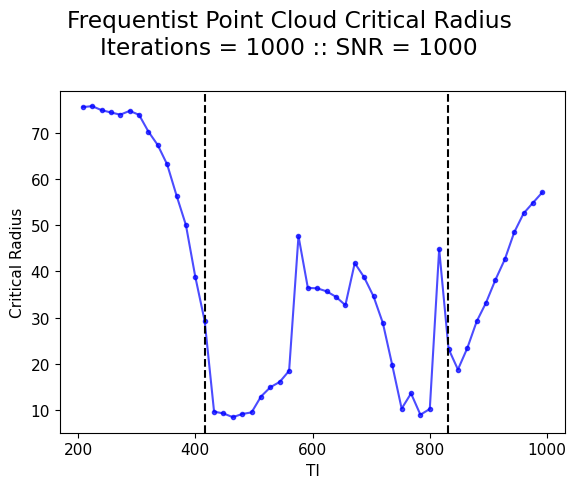

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
plt.rc('font', size = 14)
fig.suptitle(f'Frequentist Point Cloud Critical Radius\nIterations = {var_reps} :: SNR = {SNR_value}')

ax.plot(TI_DATA, ripped_diff, alpha = 0.7, color = 'b', marker = 'o', markersize = 3)

ax.set_ylabel('Critical Radius')
ax.set_xlabel('TI')
ax.axvline(x = TI1star, color = 'k', ls = '--')
ax.axvline(x = TI2star, color = 'k', ls = '--')

plt.show()


### Normed, Binned, and Threshed Data

In [118]:
norm_data, data_mins, data_maxs = normalize_data(param_estimates)

binned_data = bin_data(norm_data, 0.01)

thresh_data = thresh_bins(binned_data, 4)

In [119]:
full_ripped_diff = np.zeros(len(TI_DATA))

for iTI in trange(len(TI_DATA)):
    full_ripped_diff[iTI] = ripser(np.array(thresh_data[iTI]), maxdim = 0)['dgms'][0][-2][1]

100%|██████████| 50/50 [00:00<00:00, 945.63it/s]


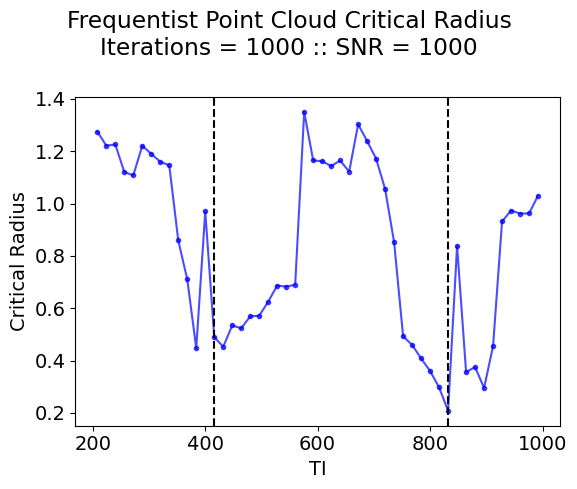

In [120]:
fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
plt.rc('font', size = 14)
fig.suptitle(f'Frequentist Point Cloud Critical Radius\nIterations = {var_reps} :: SNR = {SNR_value}')

ax.plot(TI_DATA, full_ripped_diff, alpha = 0.7, color = 'b', marker = 'o', markersize = 3)

ax.set_ylabel('Critical Radius')
ax.set_xlabel('TI')
ax.axvline(x = TI1star, color = 'k', ls = '--')
ax.axvline(x = TI2star, color = 'k', ls = '--')

plt.show()


### Centroid

In [121]:
centroids = oneCloud_estimates[:,:,:].mean(axis=1)

average_centroid_distances = np.zeros(len(TI_DATA))

#param_estimates[i, :] are all the parameters for a single TI - many noise realizations
#point is a set of the four parameters
#The L2 norm of the difference between the point and the centroid is the distance from the center of the cloud
#average centroid distance is the average L2 norm from center for a TI
for iTI in trange(len(TI_DATA)):
    average_centroid_distances[iTI] = np.mean([np.linalg.norm(point - centroids[iTI]) for point in oneCloud_estimates[iTI, :]])

#average centroid distance is the average L2 norm from center for a TI
# average_centroid_distances = average_centroid_distances.mean(axis=1)

100%|██████████| 50/50 [00:00<00:00, 267.72it/s]


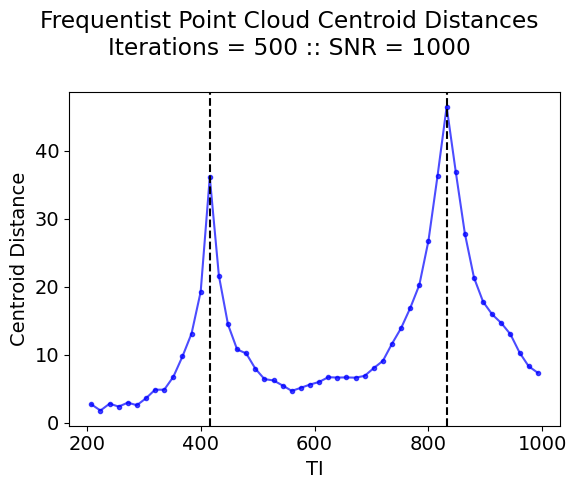

In [122]:
fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
plt.rc('font', size = 14)
fig.suptitle(f'Frequentist Point Cloud Centroid Distances\nIterations = {var_reps//2} :: SNR = {SNR_value}')

ax.plot(TI_DATA, average_centroid_distances, alpha = 0.7, color = 'b', marker = 'o', markersize = 3)

ax.set_ylabel('Centroid Distance')
ax.set_xlabel('TI')
ax.axvline(x = TI1star, color = 'k', ls = '--')
ax.axvline(x = TI2star, color = 'k', ls = '--')

plt.show()

### Selected Point Clouds

(50,)
19.265348118701816
5.611977388327267
36.31553838629351


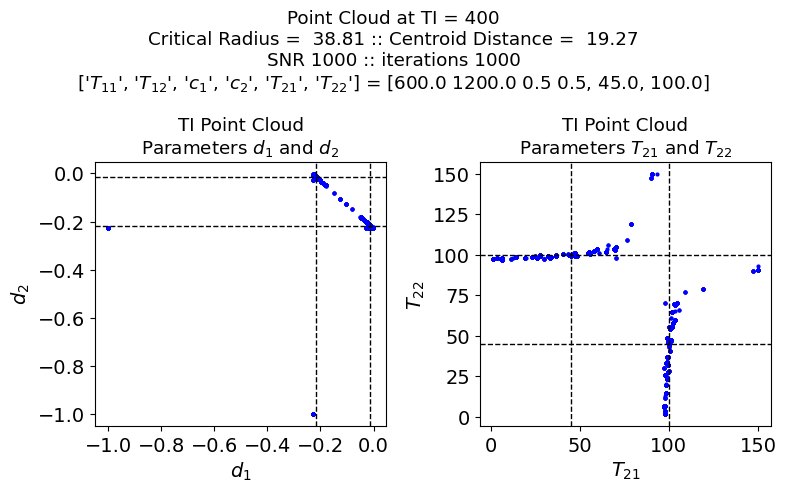

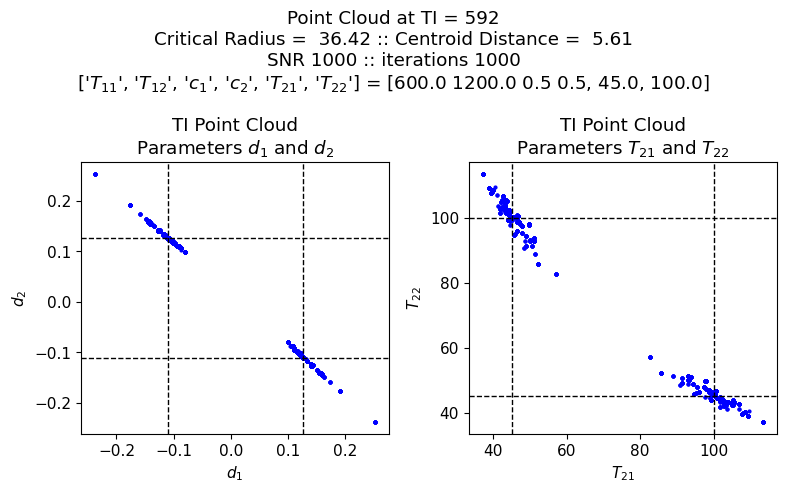

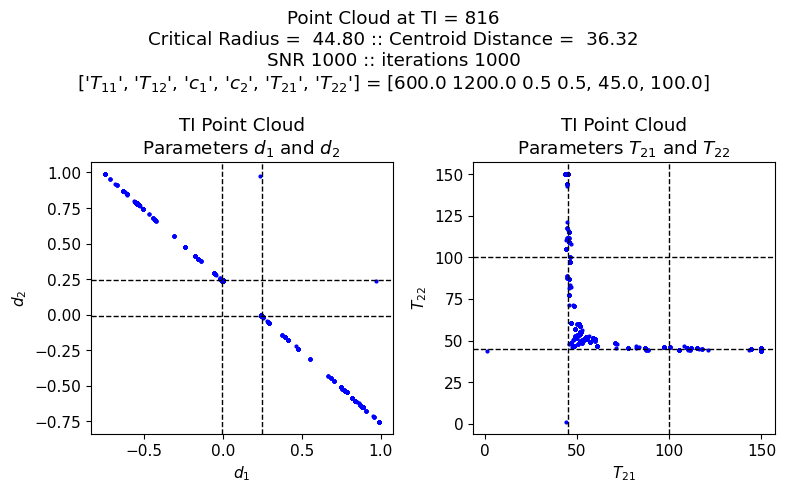

In [27]:
TI_array_oi = [400, 600, 820]
TI_array_index = [np.argmin((np.array(TI_DATA) - TI_oi)**2) for TI_oi in TI_array_oi]
print(average_centroid_distances.shape)
[print(average_centroid_distances[iTI]) for iTI in TI_array_index]

for iTI in TI_array_index:
    TI_oi = TI_DATA[iTI]

    temp_true_params = [d_value(TI_oi, c1, T11), d_value(TI_oi, c2, T12), T21, T22]

    fig, ax = plt.subplots(1,2, figsize=(8,5), tight_layout=True)
    plt.rc('font', size = 11)
    fig.suptitle(f'Point Cloud at TI = {TI_oi}\nCritical Radius = {ripped_diff[iTI]: .2f} :: Centroid Distance = {average_centroid_distances[iTI]: .2f}' + details)
    for i in range(2):
        ax[i].plot(param_estimates[iTI,:,2*i], param_estimates[iTI,:,2*i+1], ls = '', color='b', marker = 'o', markersize = 2)
        ax[i].axvline(x = temp_true_params[2*i], linewidth=1, color='k', ls = '--')
        ax[i].axvline(x = temp_true_params[2*i+1], linewidth=1, color='k', ls = '--')
        ax[i].axhline(y = temp_true_params[2*i], linewidth=1, color='k', ls = '--')
        ax[i].axhline(y = temp_true_params[2*i+1], linewidth=1, color='k', ls = '--')
        ax[i].set_xlabel(ParamTitle_4p[2*i])
        ax[i].set_ylabel(ParamTitle_4p[2*i+1])
        ax[i].set_title(f'TI Point Cloud\nParameters {ParamTitle_4p[2*i]} and {ParamTitle_4p[2*i+1]}')
        # ax[i].legend()
    plt.show()